<div style="background: linear-gradient(to right, #4b6cb7, #182848); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GenAIResultsComparator</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Advanced: LLM Metric Visualization</p>
</div>
<br>

This notebook demonstrates how to use the optional visualization functions (`plot_metric_comparison`, `plot_radar_comparison`) with pre-calculated metric results loaded from a `.pkl` file, similar to the workflow in the `llm_faq` and `DeepSeek` examples.

**Workflow:**

1. Load metric results stored in a `.pkl` file.
2. Transform these raw loaded results into a single, long-format pandas DataFrame where each row represents a specific metric score for a model. This DataFrame will contain unaggregated scores if multiple entries were present in the raw data.
3. Use the plotting functions (`plot_metric_comparison`, `plot_radar_comparison`) with this DataFrame. The plotting functions will internally aggregate these scores (e.g., using `numpy.mean` by default, or a custom function passed via the `aggregate_func` parameter) before generating the visualizations.


### 1. Import Required Libraries

For this notebook, we'll assume the library is installed or made accessible via the path modification below.


In [1]:
import sys
import os
from pprint import pprint

# Get the current working directory of the notebook
notebook_dir = os.getcwd()
# Construct the path to the project root (two levels up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import pandas as pd
import numpy as np
import pickle

from llm_metrics import (
    prepare_results_dataframe,
    plot_radar_comparison,
    plot_metric_comparison,
)

import matplotlib.pyplot as plt

### 2. Data Acquisition

We will read in the `response_metrics.pkl` file made by the `llm_faq` example. The file outputs results for each metrics on all LLMs.

In [3]:
# Use the formatted results from the `llm_faq` example
results_pkl_path = os.path.join("..", "data", "llm_faq", "data", "response_metrics.pkl")

In [4]:
with open(results_pkl_path, "rb") as f:
    results_raw = pickle.load(f)

if results_raw:
    first_model = list(results_raw.keys())[0]
    print(f"\nExample structure for model '{first_model}' (first 2 entries):")
    pprint(results_raw[first_model][:2])


Example structure for model 'phi' (first 2 entries):
[{'BERTScore': 0.529816746711731,
  'BLEU': 7.899509090909156e-05,
  'JSD': 0.197022556243571,
  'Jaccard': 0.03225806451612903,
  'Levenshtein': 0.21073558648111335,
  'ROUGE-L': 0.08333333333333333},
 {'BERTScore': 0.5143057107925415,
  'BLEU': 0.011930191477839875,
  'JSD': 0.2663774904314937,
  'Jaccard': 0.13043478260869565,
  'Levenshtein': 0.41116751269035534,
  'ROUGE-L': 0.18749999999999997}]


Since the file's format might not be directly applicable for the visualization module, we pre-process the raw results.

In [5]:
results_aggregated = {}

for model, scores_list in results_raw.items():
    # Use pandas to easily calculate mean per metric
    # Assumption that `scores_list` is a list of flat dictionaries
    df_temp = pd.DataFrame(scores_list)

    # Calculate mean, ensuring only numeric types are considered
    numeric_df = df_temp.select_dtypes(include=np.number)

    results_aggregated[model] = numeric_df.mean().to_dict()

print("\nAggregated Results (Mean Scores):\n")
pprint(results_aggregated)


Aggregated Results (Mean Scores):

{'claude': {'BERTScore': 0.5338268712162971,
            'BLEU': 0.011524330545569204,
            'JSD': 0.28080199094750286,
            'Jaccard': 0.11989625679516905,
            'Levenshtein': 0.3903965269167201,
            'ROUGE-L': 0.16074716018441465},
 'gemini': {'BERTScore': 0.4846486784517765,
            'BLEU': 0.008377109621305449,
            'JSD': 0.2567398779578286,
            'Jaccard': 0.09203854137259256,
            'Levenshtein': 0.36797425638325926,
            'ROUGE-L': 0.1385989926704349},
 'gpt': {'BERTScore': 0.5275340639054775,
         'BLEU': 0.009116592333005531,
         'JSD': 0.2779336975822413,
         'Jaccard': 0.11330561517160635,
         'Levenshtein': 0.39042037486607184,
         'ROUGE-L': 0.16030800362490275},
 'llama': {'BERTScore': 0.5274115651845932,
           'BLEU': 0.00906650922709658,
           'JSD': 0.2843576690122367,
           'Jaccard': 0.11874110119592332,
           'Levenshtein': 0.3

In [6]:
# Pass the aggregated dictionary directly
results_df = prepare_results_dataframe(results_aggregated)

print("\nPrepared DataFrame (first 5 rows):")
print(results_df.head())


Prepared DataFrame (first 5 rows):
  model_name  metric_name     score
0        phi         BLEU  0.007318
1        phi      ROUGE-L  0.132567
2        phi          JSD  0.267722
3        phi      Jaccard  0.097760
4        phi  Levenshtein  0.367957


### 3. Visualization

**3a. Bar Charts**

We first plot a bar chart comparing single metric across models.

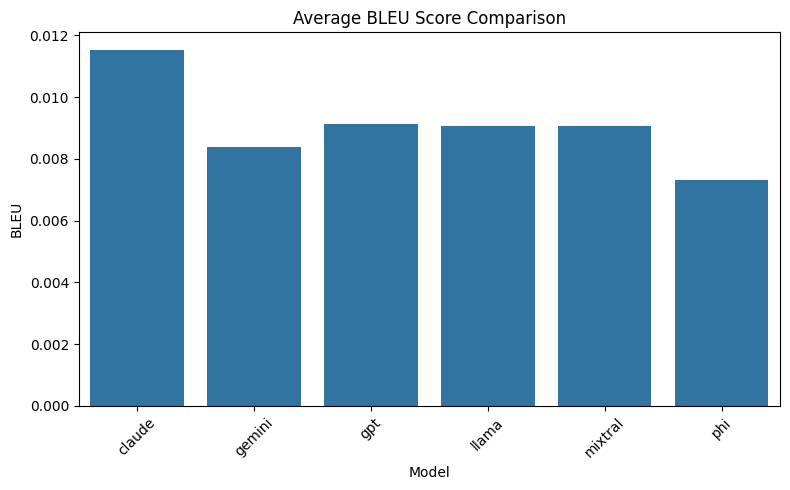

In [7]:
# Choose Metric
metric_to_plot = (
    "BLEU"  # Could change to 'ROUGE-L', 'Jaccard', 'BERTScore' etc. (must exist in results_df)
)

fig_bar, ax_bar = plt.subplots(figsize=(8, 5))

plot_metric_comparison(
    df=results_df,
    metric_name="BLEU",
    axis=ax_bar,
    title=f"Average {metric_to_plot} Score Comparison",
)
plt.show()

**3b. Radar Charts**

Now, we move to a radar chart comparing multiple metrics across models.

Note that the number of chosen metrics should be greater than 3 since radar charts are best plotted with at least 3 metrics for meaningful visualization.

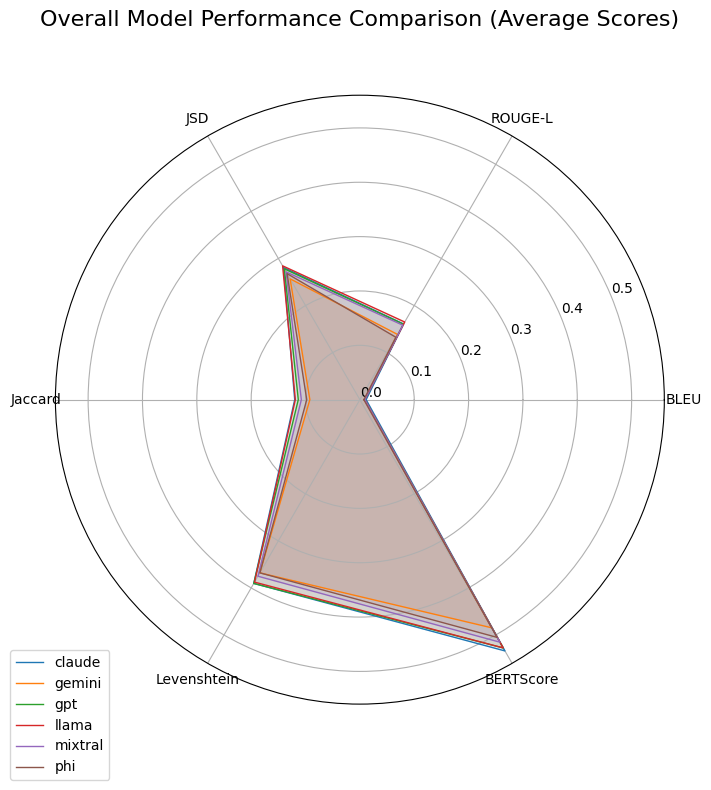

In [8]:
# Select metrics available in the aggregated results
available_metrics = results_df["metric_name"].unique().tolist()

# Either use all available metrics
metrics_for_radar = available_metrics
# Or select a subset
# metrics_for_radar = ['BLEU', 'ROUGE-L', 'BERTScore', 'Jaccard']

fig_radar, ax_radar = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

plot_radar_comparison(
    df=results_df,
    metrics=metrics_for_radar,
    axis=ax_radar,
    title="Overall Model Performance Comparison (Average Scores)",
)
plt.show()